In [ ]:
!pip install yfinance

In [97]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [98]:
forex_data_1 = yf.download('EURUSD=X', start='2020-01-01', end='2021-12-31')

[*********************100%***********************]  1 of 1 completed


In [99]:
#Removing unnecessary columns
df=forex_data_1.drop(['Open', 'High', 'Low', 'Close', 'Volume'],axis=1) 
df.rename(columns={'Adj Close': 'eur'},inplace=True) 
df.head(2)

,eur
Date,
2020-01-01,1.122083
2020-01-02,1.122083


In [100]:
df = df.dropna(axis=0)

Building Model with previous self data only

In [101]:
#Scaling the values between 0 to 1
from sklearn.preprocessing import MinMaxScaler
ss= MinMaxScaler(feature_range=(0,1))
train = ss.fit_transform(np.array(df["eur"]).reshape(-1,1))

In [102]:
# Feature selection
xtrain=[]
ytrain=[]
for i in range(60,len(train)):
    xtrain.append(train[i-60:i,0])
    ytrain.append(train[i,0])

xtrain, ytrain = np.array(xtrain), np.array(ytrain)

In [103]:
#Reshaping the train data to make it as input for LTSM layer input_shape(batchzise,timesteps,input_dim)
xtrain= np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],1))

In [104]:
xtrain.shape

(463, 60, 1)

### Build an LSTM Model

In [105]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [ ]:
#initialisizng the model 
regression= Sequential()

#First Input layer and LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(xtrain.shape[1],1)))
regression.add(Dropout(0.2))

# Where:
#     return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.

# Second LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

#Third LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

#Fourth LSTM layer with 0.2% dropout, we wont use return sequence true in last layers as we dont want to previous output
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform'))
regression.add(Dropout(0.2))
#Output layer , we wont pass any activation as its continous value model
regression.add(Dense(units=1))

#Compiling the network
regression.compile(optimizer='adam',loss='mean_squared_error')


#fitting the network
regression.fit(xtrain,ytrain,batch_size=30,epochs=100)

In [107]:
regression.save('model.h5')

In [108]:
test_df = yf.download('EURUSD=X', start='2022-01-01', end='2022-06-30')

[*********************100%***********************]  1 of 1 completed


In [109]:
test_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,1.137385,1.137592,1.128541,1.137346,1.137346,0
2022-01-04,1.130199,1.132300,1.127345,1.130224,1.130224,0
2022-01-05,1.128541,1.134559,1.127764,1.128363,1.128363,0
2022-01-06,1.131222,1.133067,1.128554,1.131350,1.131350,0
2022-01-07,1.129586,1.135976,1.129050,1.129688,1.129688,0


In [110]:
test = pd.DataFrame()

In [112]:
test['eur'] = test_df['Adj Close']

In [113]:
test = test.dropna()

In [114]:
test.head()

,eur
Date,
2022-01-03,1.137346
2022-01-04,1.130224
2022-01-05,1.128363
2022-01-06,1.131350
2022-01-07,1.129688


In [115]:

total= pd.concat([df['eur'],test['eur']],axis=0) # Concating train and test and then will take last 60 train point


In [116]:
total.head()

Date
2020-01-01    1.122083
2020-01-02    1.122083
2020-01-03    1.117144
2020-01-06    1.116196
2020-01-07    1.119799
Name: eur, dtype: float64

In [117]:
test_input = total[len(total)-len(test)-60:].values
test_input= test_input.reshape(-1,1) # reshaping it to get it transformed
test_input= ss.transform(test_input)

In [118]:
xtest= []
for i in range(60,80):
    xtest.append(test_input[i-60:i,0]) #creating input for lstm prediction

In [119]:
xtest= np.array(xtest)

In [120]:
xtest.shape

(20, 60)

In [121]:
xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))
predicted_value= regression.predict(xtest)

In [122]:
xtest.shape

(20, 60, 1)

In [123]:
predicted_value= ss.inverse_transform(predicted_value)

### Plot the Data

In [124]:
test_actual = np.array(test['eur'][0:20])

In [125]:
test_actual.shape

(20,)

In [126]:
predicted_value.shape

(20, 1)

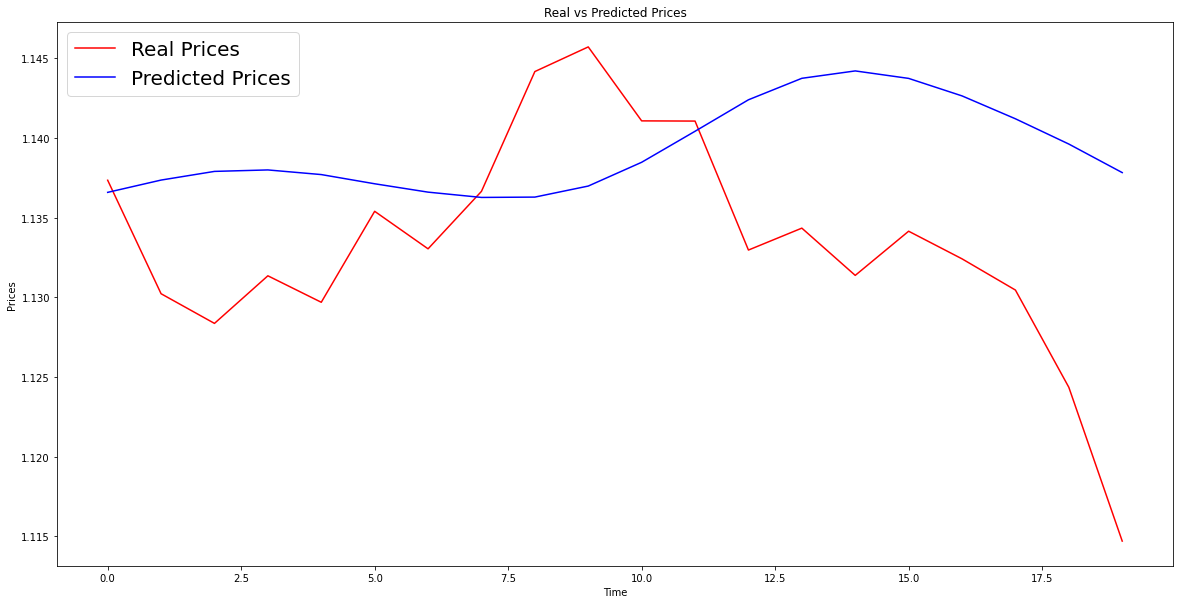

In [128]:
plt.figure(figsize=(20,10))
plt.plot(test_actual,'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)